# 训练过程，尝试不同的学习率  

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow.compat.v1 as tf
tf.disable_eager_execution()

from network import Network
from solver import train, test
from plot import plot_loss_and_acc

## 读入MNIST数据集

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

In [3]:
def decode_image(image):
    # 归一化处理
    image = tf.cast(image, tf.float32)
    image = tf.reshape(image, [784])
    image = image / 255.0
    image = image - tf.reduce_mean(image)
    return image

def decode_label(label):
    # 将标签变为one-hot编码
    return tf.one_hot(label, depth=10)

In [4]:
# 数据预处理
x_train = tf.data.Dataset.from_tensor_slices(x_train).map(decode_image)
y_train = tf.data.Dataset.from_tensor_slices(y_train).map(decode_label)
data_train = tf.data.Dataset.zip((x_train, y_train))

x_test = tf.data.Dataset.from_tensor_slices(x_test).map(decode_image)
y_test = tf.data.Dataset.from_tensor_slices(y_test).map(decode_label)
data_test = tf.data.Dataset.zip((x_test, y_test))

In [5]:
import time
from criterion import EuclideanLossLayer,SoftmaxCrossEntropyLossLayer
from optimizer import SGD
from layers import FCLayer, SigmoidLayer, ReLULayer

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import pandas as pd
exec_result = pd.DataFrame(columns=['mode','batch_size','learning_rate_SGD', 'momentum','weight_decay','time','loss_validate','acc_validate'])

max_epoch = 20
disp_freq = 50
init_std = 0.01

In [6]:
batch_size = 100
weight_decay = 0.1

for learning_rate_SGD in [0.0005, 0.001, 0.002, 0.006, 0.01]:
    #Euclidean+Sigmoid
    momentum = 0.55
    criterion = EuclideanLossLayer()
    sgd = SGD(learning_rate_SGD, weight_decay,momentum)
    t1=time.time()
    sigmoidMLP = Network()
    # 使用FCLayer和SigmoidLayer构建多层感知机
    # 128为隐含层的神经元数目
    sigmoidMLP.add(FCLayer(784, 128))
    sigmoidMLP.add(SigmoidLayer())
    sigmoidMLP.add(FCLayer(128, 10))
    sigmoidMLP, sigmoid_loss, sigmoid_acc = train(sigmoidMLP, criterion, sgd, data_train, max_epoch, batch_size, disp_freq)
    t2=time.time()
    exec_result.loc[exec_result.shape[0]] = ['Euclidean_Sigmoid',batch_size, learning_rate_SGD, momentum, weight_decay, t2-t1,sigmoid_loss, sigmoid_acc]   

    #Euclidean+ReLU
    momentum = 0.99
    criterion = EuclideanLossLayer()
    sgd = SGD(learning_rate_SGD, weight_decay,momentum)
    t1=time.time()
    reluMLP = Network()
    # 使用FCLayer和ReLULayer构建多层感知机
    reluMLP.add(FCLayer(784, 128))
    reluMLP.add(ReLULayer())
    reluMLP.add(FCLayer(128, 10))
    reluMLP, relu_loss, relu_acc = train(reluMLP, criterion, sgd, data_train, max_epoch, batch_size, disp_freq)
    t2=time.time()
    exec_result.loc[exec_result.shape[0]] = ['Euclidean_ReLU',batch_size, learning_rate_SGD, momentum, weight_decay, t2-t1,relu_loss, relu_acc]     

    #CrossEntropy+Sigmoid
    momentum = 0.55
    criterion = SoftmaxCrossEntropyLossLayer()
    sgd = SGD(learning_rate_SGD, weight_decay,momentum)
    t1=time.time()
    sigmoidMLP = Network()
    # 使用FCLayer和SigmoidLayer构建多层感知机
    # 128为隐含层的神经元数目
    sigmoidMLP.add(FCLayer(784, 128))
    sigmoidMLP.add(SigmoidLayer())
    sigmoidMLP.add(FCLayer(128, 10))
    sigmoidMLP, sigmoid_loss, sigmoid_acc = train(sigmoidMLP, criterion, sgd, data_train, max_epoch, batch_size, disp_freq)
    t2=time.time()
    exec_result.loc[exec_result.shape[0]] = ['CrossEntropy_Sigmoid',batch_size, learning_rate_SGD, momentum, weight_decay, t2-t1,sigmoid_loss, sigmoid_acc]         

    #CrossEntropy+ReLU
    momentum = 0.99
    criterion = SoftmaxCrossEntropyLossLayer()
    sgd = SGD(learning_rate_SGD, weight_decay,momentum)
    reluMLP = Network()
    t1=time.time()
    # 使用FCLayer和SigmoidLayer构建多层感知机
    # 128为隐含层的神经元数目
    reluMLP.add(FCLayer(784, 128))
    reluMLP.add(ReLULayer())
    reluMLP.add(FCLayer(128, 10))
    reluMLP, relu_loss, relu_acc = train(reluMLP, criterion, sgd, data_train, max_epoch, batch_size, disp_freq)
    t2=time.time()
    exec_result.loc[exec_result.shape[0]] = ['CrossEntropy_ReLU',batch_size, learning_rate_SGD, momentum, weight_decay, t2-t1,relu_loss, relu_acc]      

Instructions for updating:
This is a deprecated API that should only be used in TF 1 graph mode and legacy TF 2 graph mode available through `tf.compat.v1`. In all other situations -- namely, eager mode and inside `tf.function` -- you can consume dataset elements using `for elem in dataset: ...` or by explicitly creating iterator via `iterator = iter(dataset)` and fetching its elements via `values = next(iterator)`. Furthermore, this API is not available in TF 2. During the transition from TF 1 to TF 2 you can use `tf.compat.v1.data.make_one_shot_iterator(dataset)` to create a TF 1 graph mode style iterator for a dataset created through TF 2 APIs. Note that this should be a transient state of your code base as there are in general no guarantees about the interoperability of TF 1 and TF 2 code.
Epoch [0][20]	 Batch [0][550]	 Training Loss 6.6855	 Accuracy 0.0500
Epoch [0][20]	 Batch [50][550]	 Training Loss 2.1397	 Accuracy 0.0939
Epoch [0][20]	 Batch [100][550]	 Training Loss 1.4183	 A

In [7]:
exec_result['acc_validate_float'] = exec_result['acc_validate'].map(lambda x: np.average(x))
exec_result

,mode,batch_size,learning_rate_SGD,momentum,weight_decay,time,loss_validate,acc_validate,acc_validate_float
0,Euclidean_Sigmoid,100,0.0005,0.55,0.1,42.096602,"[0.4914428218448918, 0.39959506525217914, 0.35...","[0.2724, 0.472, 0.6004, 0.672, 0.7172000000000...",0.74087
1,Euclidean_ReLU,100,0.0005,0.99,0.1,47.704532,"[0.24047787080862879, 0.2166288237172462, 0.21...","[0.7859999999999999, 0.8183999999999999, 0.839...",0.84218
2,CrossEntropy_Sigmoid,100,0.0005,0.55,0.1,83.358217,"[2.212622054769259, 2.109718028883581, 2.03657...","[0.2292, 0.47820000000000007, 0.583, 0.6286, 0...",0.65749
3,CrossEntropy_ReLU,100,0.0005,0.99,0.1,42.699836,"[0.813166220546415, 0.7830218922774967, 0.7773...","[0.8813999999999999, 0.8876000000000001, 0.885...",0.88199
4,Euclidean_Sigmoid,100,0.0010,0.55,0.1,55.676048,"[0.39311269810378996, 0.32568242532731645, 0.3...","[0.4778, 0.6592, 0.735, 0.7709999999999999, 0....",0.75738
5,Euclidean_ReLU,100,0.0010,0.99,0.1,84.719046,"[0.22165937413291115, 0.21279213983248396, 0.2...","[0.8058, 0.8432, 0.8462000000000001, 0.8478, 0...",0.84806
6,CrossEntropy_Sigmoid,100,0.0010,0.55,0.1,64.320768,"[2.0718474211961104, 1.9576745433813876, 1.896...","[0.49860000000000004, 0.6481999999999999, 0.70...",0.68376
7,CrossEntropy_ReLU,100,0.0010,0.99,0.1,85.607813,"[0.7866840359214984, 0.7841500179240483, 0.777...","[0.8876000000000002, 0.8867999999999999, 0.888...",0.88437
8,Euclidean_Sigmoid,100,0.0020,0.55,0.1,69.527462,"[0.33403575187280476, 0.29639777143887264, 0.2...","[0.6318, 0.7574, 0.7931999999999999, 0.7994, 0...",0.68997
9,Euclidean_ReLU,100,0.0020,0.99,0.1,86.643758,"[0.21305107595462974, 0.20916735914071669, 0.2...","[0.8211999999999999, 0.8492000000000002, 0.848...",0.84762


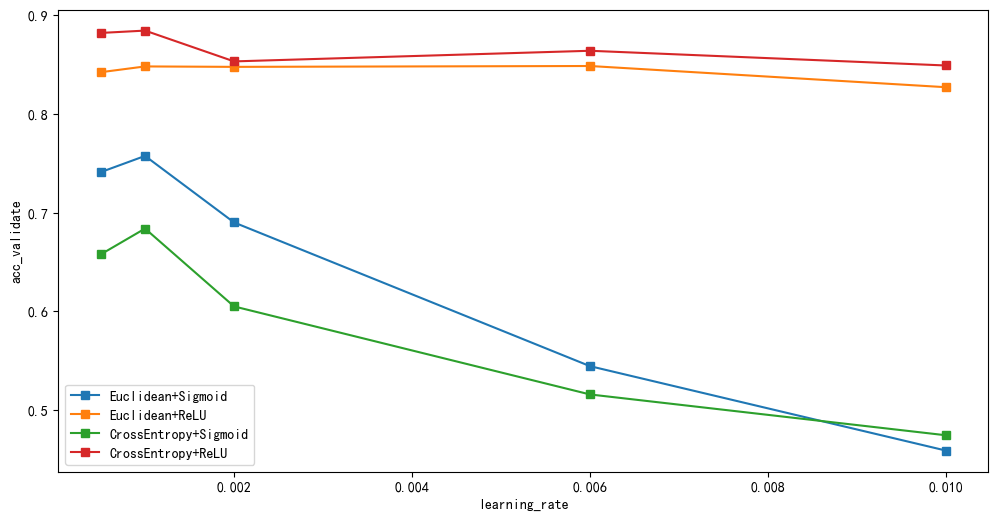

In [3]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6), dpi=100)
plt.rcParams['font.sans-serif']=['SimHei']
plt.plot(exec_result.query("mode == 'Euclidean_Sigmoid'")['learning_rate_SGD'], exec_result.query("mode == 'Euclidean_Sigmoid'")['acc_validate_float'], marker='s', label = 'Euclidean+Sigmoid')
plt.plot(exec_result.query("mode == 'Euclidean_Sigmoid'")['learning_rate_SGD'], exec_result.query("mode == 'Euclidean_ReLU'")['acc_validate_float'], marker='s', label = 'Euclidean+ReLU')
plt.plot(exec_result.query("mode == 'Euclidean_Sigmoid'")['learning_rate_SGD'], exec_result.query("mode == 'CrossEntropy_Sigmoid'")['acc_validate_float'], marker='s', label = 'CrossEntropy+Sigmoid')
plt.plot(exec_result.query("mode == 'Euclidean_Sigmoid'")['learning_rate_SGD'], exec_result.query("mode == 'CrossEntropy_ReLU'")['acc_validate_float'], marker='s', label = 'CrossEntropy+ReLU')
plt.xlabel('learning_rate')
plt.ylabel('acc_validate')
plt.legend()

In [2]:
exec_result.to_csv('./result/result_learning_rate_SGD.csv',index=False)
# # euclidean_sigmoid.learning_rate_SGD, euclidean_relu.learning_rate_SGD, crossEntropy_sigmoid.learning_rate_SGD, crossEntropy_relu.learning_rate_SGD

# exec_result=pd.read_csv('./result_learning_rate_SGD.csv')